# Profile of `maze_dataset` Dumping and Loading

In [1]:
import os
import itertools
from typing import Callable, Any
import cProfile
import pstats
import copy
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from muutils.statcounter import StatCounter

from maze_dataset.dataset.maze_dataset import (
    MazeDataset,
    MazeDatasetConfig,
)
from maze_dataset.generation.generators import GENERATORS_MAP
from maze_dataset.utils import timeit_fancy, FancyTimeitResult

## Generate Datasets


In [2]:
cfgs: list[MazeDatasetConfig] = [
    MazeDatasetConfig(
		name="test",
		grid_n=grid_n,
		n_mazes=n_mazes,
		maze_ctor=GENERATORS_MAP['gen_dfs'],
	)
    for grid_n, n_mazes in itertools.product(
		[10],
		np.logspace(0, 4, 9, dtype=int).tolist(),
	)
]

datasets: list[MazeDataset] = [MazeDataset.from_config(cfg) for cfg in cfgs]

## Profile

In [3]:
columns: list[str] = ['grid_n', 'n_mazes', 'serialize', 'serialize_minimal', 'load', 'load_minimal', 'save', 'save_minimal', 'read', 'read_minimal']
speeds_data: list[dict] = list()


In [4]:
def wrapped_timeit_fancy(
        name: str,
        function: Callable,
        do_profiling: bool,
        repeats: int,
        timing_stat: Callable[[StatCounter], float],
    ) -> tuple[dict, Any]:
    output: dict = dict()

    result: FancyTimeitResult = timeit_fancy(
        function,
        get_return=True,
        do_profiling=do_profiling,
        repeats=repeats,
    )

    output[name] = timing_stat(result.timings)
    output[f"{name}:stats"] = result.timings
    if do_profiling:
        output[f"{name}:profiling"] = result.profile

    return output, result.return_value



def measure_dataset_speed(
        d: MazeDataset, 
        do_profiling: bool = True,
        repeats: int = 1,
        timing_stat: Callable[[StatCounter], float] = StatCounter.min,
    ) -> dict:
    if repeats > 1:
        warnings.warn("Repeats > 1, results might not be accurate due to generation metadata being collected.")
    kwargs_fancy_timeit: dict = dict(
        do_profiling=do_profiling,
        timing_stat=timing_stat,
        repeats=repeats,
    )
    d.cfg.serialize_minimal_threshold = None
    _d_cpy: MazeDataset = copy.deepcopy(d)
    # set up row data
    row_data: dict = dict(
        grid_n=d.cfg.grid_n,
        n_mazes=d.cfg.n_mazes,
    )
    # serialization & loading
    info_serialize, result_serialize = wrapped_timeit_fancy(
        'serialize', _d_cpy.serialize, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize)
    _d_cpy = copy.deepcopy(d)

    info_serialize_min, result_serialize_min = wrapped_timeit_fancy(
        'serialize_minimal', _d_cpy._serialize_minimal, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_min)
    _d_cpy = copy.deepcopy(d)

    info_serialize_min_alt, result_serialize_min_alt = wrapped_timeit_fancy(
        'serialize_minimal_alt', _d_cpy._serialize_minimal_alt, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_min_alt)
    _d_cpy = copy.deepcopy(d)

    row_data.update(wrapped_timeit_fancy(
        'load', lambda: MazeDataset.load(result_serialize), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_minimal', lambda: MazeDataset._load_minimal(result_serialize_min), **kwargs_fancy_timeit
    )[0])
    
    # saving and loading
    path_default: str = f'../data/{d.cfg.to_fname()}.zanj'
    path_min: str = f'../data/{d.cfg.to_fname()}_min.zanj'

    # default
    d.cfg.serialize_minimal_threshold = None
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save', lambda: _d_cpy.save(file_path=path_default), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)

    row_data.update(wrapped_timeit_fancy(
        'read', lambda: MazeDataset.read(file_path=path_default), **kwargs_fancy_timeit
    )[0])

    # minimal
    d.cfg.serialize_minimal_threshold = 0
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save_minimal', lambda: _d_cpy.save(file_path=path_min), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)
    
    row_data.update(wrapped_timeit_fancy(
        'read_minimal', lambda: MazeDataset.read(file_path=path_min), **kwargs_fancy_timeit
    )[0])

    # asserts
    # assert d == read_default
    # assert d == read_minimal

    # reset cfg?
    d.cfg.serialize_minimal_threshold = None

    return row_data

## Profile small datasets only

In [5]:
for i, d in enumerate(datasets):
    print(f'Profiling {i+1}/{len(datasets)}:\t{d.cfg}')
    result = measure_dataset_speed(d)
    speeds_data.append(result)
    cols_short: str = str({k : v for k,v in result.items() if ':' not in k})
    print(f"\t{cols_short}")
    print(f"\t{str(d.cfg)}")

Profiling 1/9:	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000016D5B2CCFE0>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)
	{'grid_n': 10, 'n_mazes': 1, 'serialize': 0.0056597000220790505, 'serialize_minimal': 0.004361499915830791, 'serialize_minimal_alt': 0.00318250001873821, 'load': 0.006519299931824207, 'load_minimal': 0.0038376000011339784, 'save': 0.019425899954512715, 'read': 0.012073300080373883, 'save_minimal': 0.021624299930408597, 'read_minimal': 0.009782100096344948}
	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}], grid_n=10, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000016D5B2CCFE0>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)
Profiling 2/9:	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512,

### Results

In [6]:
SPEEDS: pd.DataFrame = pd.DataFrame(speeds_data)

def compute_speedups(speeds: pd.DataFrame, column_measurement_prefixes: list[str] = ['serialize', 'load', 'save', 'read']) -> pd.DataFrame:
    for prefix in column_measurement_prefixes:
        speeds[f'{prefix}_speedup'] = speeds[f'{prefix}'] / speeds[f'{prefix}_minimal']
    return speeds

SPEEDS = compute_speedups(SPEEDS)

In [7]:
SPEEDS[[c for c in SPEEDS.columns if ':' not in c]]

,grid_n,n_mazes,serialize,serialize_minimal,serialize_minimal_alt,load,load_minimal,save,read,save_minimal,read_minimal,serialize_speedup,load_speedup,save_speedup,read_speedup
0,10,1,0.005660,0.004361,0.003183,0.006519,0.003838,0.019426,0.012073,0.021624,0.009782,1.297650,1.698796,0.898337,1.234224
1,10,3,0.002064,0.005746,0.002318,0.009768,0.003653,0.023225,0.016174,0.019119,0.010704,0.359240,2.674031,1.214746,1.511005
2,10,10,0.005896,0.004244,0.003472,0.024452,0.004291,0.041193,0.031060,0.016928,0.009814,1.389490,5.698797,2.433357,3.164739
3,10,31,0.001887,0.006933,0.007739,0.066990,0.003558,0.090605,0.075653,0.019854,0.010443,0.272194,18.828635,4.563585,7.244195
4,10,100,0.002533,0.017948,0.014320,0.238146,0.005614,0.240836,0.228269,0.024386,0.011362,0.141151,42.423062,9.875861,20.089823
5,10,316,0.003683,0.053191,0.042541,0.659431,0.007978,0.257785,0.710864,0.040599,0.015035,0.069241,82.658264,6.349453,47.280264
6,10,1000,0.008429,0.153597,0.130451,2.097887,0.017441,0.758231,2.278307,0.098729,0.029550,0.054875,120.282035,7.679955,77.099796
7,10,3162,0.018411,0.179079,0.076725,0.479464,0.048808,2.347182,7.022554,0.256781,0.062734,0.102808,9.823461,9.140799,111.941396
8,10,10000,0.052055,0.543880,0.223649,1.459750,0.142821,7.446651,22.619794,0.863896,0.174735,0.095711,10.220828,8.619845,129.451696


Plotting serialize timings and speedups
Plotting grid_n=10
Plotting load timings and speedups
Plotting grid_n=10
Plotting save timings and speedups
Plotting grid_n=10
Plotting read timings and speedups
Plotting grid_n=10


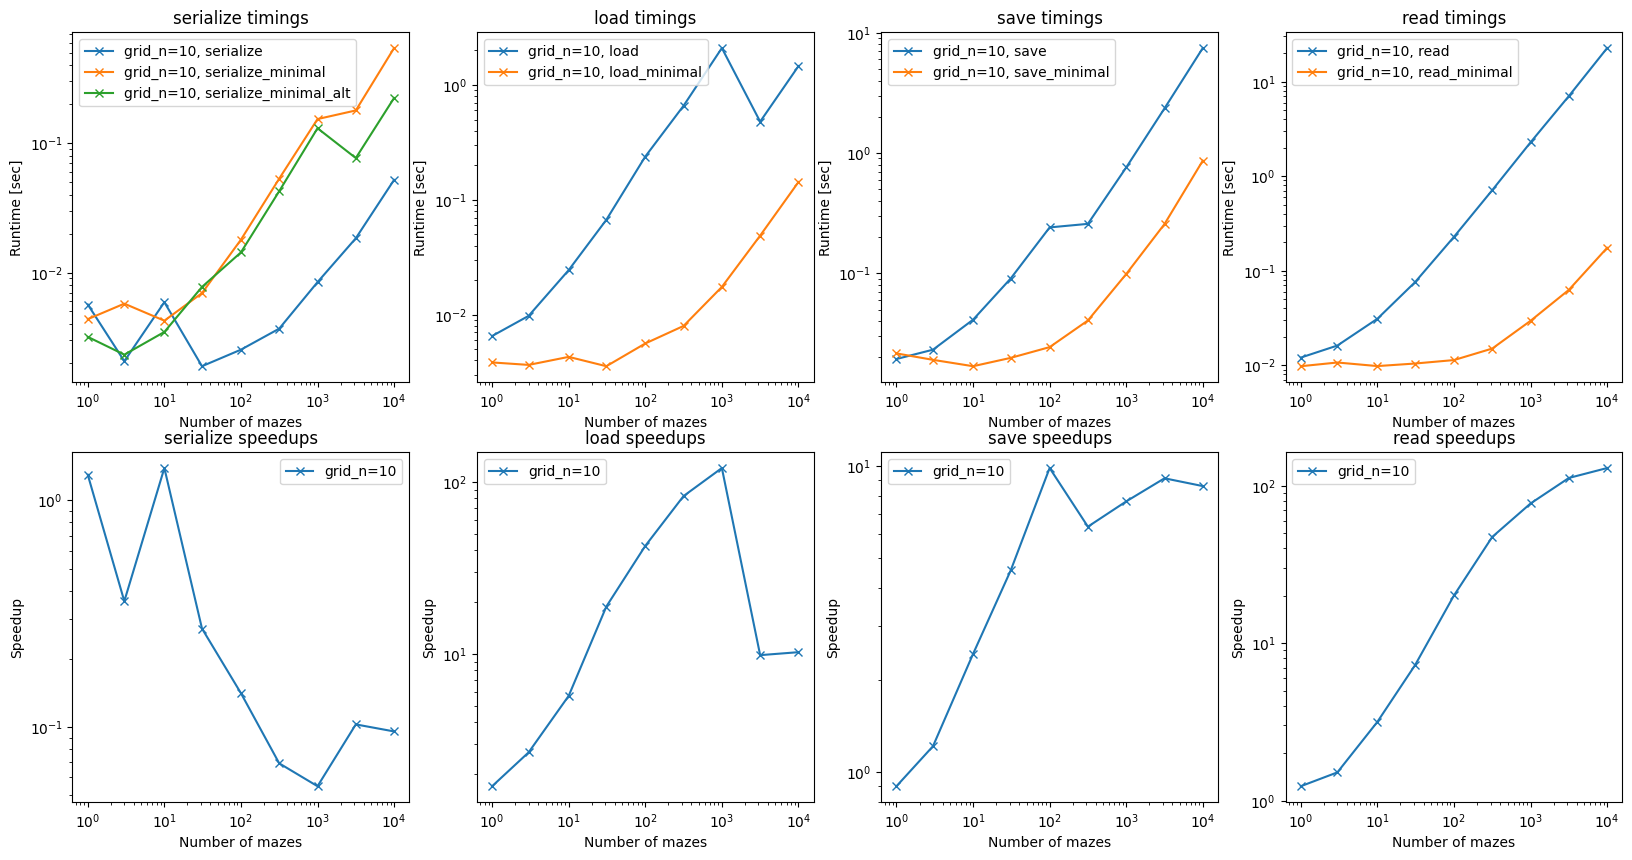

In [8]:
def plot_speeds(speeds: pd.DataFrame, column_measurement_prefixes: list[str] = ['serialize', 'load', 'save', 'read']) -> None:
    n_measurements: int = len(column_measurement_prefixes)
    fig, axs = plt.subplots(2, n_measurements, figsize=(n_measurements*5, 10))

    unique_grid_ns: list[int] = speeds['grid_n'].unique().tolist()

    for i, prefix in enumerate(column_measurement_prefixes):
        print(f'Plotting {prefix} timings and speedups')
        for grid_n in unique_grid_ns:
            print(f'Plotting grid_n={grid_n}')
            # raw timings
            ax_timings = axs[0, i]
            speeds_masked = speeds[speeds['grid_n'] == grid_n].sort_values('n_mazes')
            x_n_mazes = speeds_masked['n_mazes']

            # Plotting
            ax_timings.plot(x_n_mazes, speeds_masked[f'{prefix}'], "x-", label=f'grid_n={grid_n}, {prefix}')
            ax_timings.plot(x_n_mazes, speeds_masked[f'{prefix}_minimal'], "x-", label=f'grid_n={grid_n}, {prefix}_minimal')

            _alt = f'{prefix}_minimal_alt'
            if _alt in speeds.columns:
                ax_timings.plot(x_n_mazes, speeds_masked[_alt], "x-", label=f'grid_n={grid_n}, {_alt}')

            # Setting multiple properties with `set`
            ax_timings.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Runtime [sec]', title=f'{prefix} timings')
            ax_timings.legend()

            # speedups
            ax_speedups = axs[1, i]
            ax_speedups.plot(x_n_mazes, speeds_masked[f'{prefix}_speedup'], "x-", label=f'grid_n={grid_n}')

            # Setting multiple properties with `set` for ax_speedups
            ax_speedups.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Speedup', title=f'{prefix} speedups')
            ax_speedups.legend()


plot_speeds(SPEEDS)


Comparing rows 2 and 4, it appears that the `grid_n` has a relatively small effect on `serialize` and `load` runtimes. Those functions appear to run in $O(n_{\mathrm{mazes}})$ time. `grid_n` does impact `save` and `read`, but not their `_minimal` counterparts as much.

To compare the speed of analogous procedures vs `n_mazes`, the plots below show data from `speeds.loc[3:,:]`.

In [9]:
SPEEDS[['grid_n', 'n_mazes', 'serialize_minimal_alt:profiling']]

,grid_n,n_mazes,serialize_minimal_alt:profiling
0,10,1,<pstats.Stats object at 0x0000016D6A8207D0>
1,10,3,<pstats.Stats object at 0x0000016D7667A250>
2,10,10,<pstats.Stats object at 0x0000016D7672FF50>
3,10,31,<pstats.Stats object at 0x0000016D6A769950>
4,10,100,<pstats.Stats object at 0x0000016D5C46C310>
5,10,316,<pstats.Stats object at 0x0000016D7653C910>
6,10,1000,<pstats.Stats object at 0x0000016D5B3B1690>
7,10,3162,<pstats.Stats object at 0x0000016D5CD23B10>
8,10,10000,<pstats.Stats object at 0x0000016D5D4DEBD0>


In [12]:
SPEEDS['serialize_minimal_alt:profiling'][8].sort_stats('cumulative').print_stats(20)

         56049 function calls (55824 primitive calls) in 0.050 seconds

   Ordered by: cumulative time
   List reduced from 84 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.028    0.028    0.050    0.050 maze_dataset.py:380(_serialize_minimal_alt)
    10000    0.009    0.000    0.009    0.000 {built-in method numpy.array}
        1    0.001    0.001    0.006    0.006 {built-in method builtins.max}
        2    0.000    0.000    0.005    0.003 json_serialize.py:271(json_serialize)
    195/2    0.000    0.000    0.005    0.003 json_serialize.py:231(json_serialize)
    10001    0.004    0.000    0.005    0.000 maze_dataset.py:386(<genexpr>)
        1    0.000    0.000    0.005    0.005 json_serialize.py:124(_serialize_override_serialize_func)
        1    0.000    0.000    0.005    0.005 serializable_dataclass.py:356(serialize)
        1    0.000    0.000    0.005    0.005 maze_dataset.py:62(<lambda>)
        1    0.0